# Bottom-up model

Our objective is to create a simulator scenario. It should model how our orders would behave if we changed a few parameters.

##### Imports

In [1]:
import numpy as np
import pandas as pd
import s3fs
import fbprophet
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics

#### Reading data
We will gather the necessary information to fit our prediction models.  
Our dataframes are hosted in s3.

In [2]:
data = pd.read_csv('s3://bsa-correlation-one/electronics_data.csv', dtype={'gtin':'str'})

In [3]:
data['delta_price'] = (data.olist_price.values/data.competition_price.values)-1

In [4]:
df = data[['date', 'product_group','product_type', 'olist_price','delta_price', 'orders']].copy()

In [5]:
df['olist_price'] = round(df.olist_price,2)

In [6]:
df['delta_price'] = round(df.delta_price,3)

In [43]:
df.head(2)

,date,product_group,product_type,olist_price,delta_price,orders,price_category
0,2019-05-06,electronics,Adaptador eletrônico,69.99,NaN,0.0,D
1,2019-05-07,electronics,Adaptador eletrônico,69.99,NaN,0.0,D


### Create price categories

Working with each product individually would be infeasible, as some of them have extremely short and/or volatile and/or sparse time series. In order to mitigate such behaviors, we grouped each product taking its type and price range into consideration.  
For example: Cellphones prices were categorized with respect to the prices distribution for this product type. Every product that had lower prices than its 25-th percentile was categorized as 'A', then 'B' for products cheaper than the 50-th percentile, 'C' for products cheaper then the 75-th percentile. All other products were categorized as 'D'.  
Then, we finally concatenate the product's group, type and price range category into one column.
A different model will be fit to each of these combinations.

In [7]:
price_cat = {}
for prod_type in df.product_type.unique():
    temp = df[df.product_type == prod_type].copy()
    price_cat[prod_type] = np.quantile(temp.olist_price.values, np.arange(0.25,1,0.25))

In [8]:
def price_range(prod_category, price):
    prices = price_cat[prod_category]
    if price < prices[0]:
        return 'A'
    elif price < prices[1]:
        return 'B'
    elif price < prices[2]:
        return 'C'
    else:
        return 'D'

In [9]:
df['price_category'] = df.apply(lambda row: price_range(row['product_type'], row['olist_price']), axis=1)

In [10]:
df_gr = df.groupby(['date','product_group','product_type','price_category'])\
          .agg({'orders':'sum', 'delta_price': 'mean'}).reset_index()

In [11]:
df_gr.head()

,date,product_group,product_type,price_category,orders,delta_price
0,2017-06-30,electronics,Celular,A,0.0,NaN
1,2017-06-30,electronics,Celular,B,0.0,NaN
2,2017-06-30,electronics,Celular,C,0.0,NaN
3,2017-06-30,electronics,Controle remoto,D,0.0,NaN
4,2017-06-30,electronics,Microfone,A,0.0,NaN


In [12]:
df_gr['group_type_price'] = df_gr.product_group + '_' + df_gr.product_type + '_' +df_gr.price_category

In [13]:
df_final = df_gr[['date','group_type_price','delta_price', 'orders']].copy()

In [14]:
df_final['date'] = pd.to_datetime(df_final['date'])

In [15]:
df_final.rename(columns={'date':'ds', 'orders':'y'}, inplace=True)

In [16]:
df_final.head()

,ds,group_type_price,delta_price,y
0,2017-06-30,electronics_Celular_A,NaN,0.0
1,2017-06-30,electronics_Celular_B,NaN,0.0
2,2017-06-30,electronics_Celular_C,NaN,0.0
3,2017-06-30,electronics_Controle remoto_D,NaN,0.0
4,2017-06-30,electronics_Microfone_A,NaN,0.0


### Holidays

Let's create a dataframe with the most important holidays that could affect sales.

In [17]:
def get_holidays():
    """
    Get Black Friday dates
    """
    black_friday = pd.DataFrame({
                  'holiday': 'black_friday',
                  'ds': pd.to_datetime(['2017-11-24', '2018-11-23', '2019-11-29',
                                        '2020-11-27', '2021-11-26', '2022-11-25',
                                        '2023-11-24', '2024-11-29', '2025-11-28']),
                  'lower_window': -1,
                  'upper_window': 3,
                })

    xmas = pd.DataFrame({
                  'holiday': 'christmas',
                  'ds': pd.to_datetime(['2017-12-25', '2018-12-25', '2019-12-25',
                                        '2020-12-25', '2021-12-25', '2022-12-25',
                                        '2023-12-25', '2024-12-25', '2025-12-25']),
                  'lower_window': -1,
                  'upper_window': 0,
                })

    new_year = pd.DataFrame({
                  'holiday': 'new_year',
                  'ds': pd.to_datetime(['2017-01-01', '2018-01-01', '2019-01-01',
                                        '2020-01-01', '2021-01-01', '2022-01-01',
                                        '2023-01-01', '2024-01-01', '2025-01-01']),
                  'lower_window': -1,
                  'upper_window': 0,
                })

    carnival = pd.DataFrame({
                  'holiday': 'carnival',
                  'ds': pd.to_datetime(['2017-02-28', '2018-02-13', '2019-03-05',
                                        '2020-02-25', '2021-02-16', '2022-03-01',
                                        '2023-02-21', '2024-02-13', '2025-03-04']),
                  'lower_window': -1,
                  'upper_window': 0,
                })

    good_friday = pd.DataFrame({
                  'holiday': 'good_friday',
                  'ds': pd.to_datetime(['2018-03-18','2019-04-19','2020-04-10',
                                        '2021-04-02','2022-04-15','2023-04-07',
                                        '2024-03-29']),
                  'lower_window': 0,
                  'upper_window': 2,
                })

    # long holidays

    monday = pd.DataFrame({
                  'holiday': 'monday',
                  'ds': pd.to_datetime(['2020-09-07','2020-10-12','2020-11-02',
                                        '2021-11-15']),
                  'lower_window': -2,
                  'upper_window': 0,
                })

    friday = pd.DataFrame({
                  'holiday': 'friday',
                  'ds': pd.to_datetime(['2018-09-07','2018-10-12','2018-11-02',
                                        '2019-11-15','2020-05-01']),
                  'lower_window': 0,
                  'upper_window': 2,
                })

    # Different cases
    # 2019-12-30 (christmas and New year's eve from tuesday to wednesday. Monday was also affected)
    others = pd.DataFrame({
                  'holiday': 'others',
                  'ds': pd.to_datetime(['2019-12-23','2019-12-30']),
                  'lower_window': 0,
                  'upper_window': 0,
                })

    holidays = pd.concat((black_friday, xmas, new_year, carnival,
                         monday, friday, others))

    return holidays

In [18]:
holidays = get_holidays()

### Bottom-up prophet

Below, you can see the first draft of the modeling process.  
In the example below, we predicted a few scenarios for the cheapest (price category 'A') for cellphones.

# Create models
We start by fitting models for each product group_type_pricerange. We then save such models to a dictionary.

In [20]:
start = datetime.now()
models = {}
deltas = {}

for each in df_final.group_type_price.unique(): # each in df_final.group_type_price.unique()['electronics_Celular_A']
    try:
        temp = df_final[df_final['group_type_price']==each].copy()
        # fillna values with mean?
        temp['delta_price'] = temp.delta_price.fillna(value=temp.delta_price.mean())
        deltas[each] = temp['delta_price'].tolist()

        model = Prophet(yearly_seasonality=True, holidays=holidays,
                        interval_width=0.95, seasonality_mode='multiplicative')
        model.add_regressor('delta_price')
        model.fit(temp)


        models[each] = model
    except Exception as e:
        print('Failed ', each)
        print(e)
        pass
        
end = datetime.now()
print('Executed in {}'.format(end-start))

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

Failed  electronics_Interface de áudio_D
Found NaN in column 'delta_price'


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

Failed  electronics_Micro system_D
Found NaN in column 'delta_price'


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Failed  electronics_Capa para smartwatch_B
Found NaN in column 'delta_price'


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 13.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 13.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Failed  electronics_Bateria para filmadora_D
Found NaN in column 'delta_price'


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

Failed  electronics_Interface de áudio_C
Found NaN in column 'delta_price'


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Failed  electronics_Bateria para filmadora_C
Found NaN in column 'delta_price'
Failed  electronics_Micro system_A
Dataframe has less than 2 non-NaN rows.


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

Failed  electronics_Capa para smartwatch_A
Found NaN in column 'delta_price'


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Failed  electronics_Kit touch e display_A
Found NaN in column 'delta_price'
Failed  electronics_Kit touch e display_C
Found NaN in column 'delta_price'


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Failed  electronics_Interface de áudio_A
Found NaN in column 'delta_price'
Failed  electronics_Strobo_A
Found NaN in column 'delta_price'


INFO:fbprophet:n_changepoints greater than number of observations. Using 1.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Failed  electronics_Strobo_D
Found NaN in column 'delta_price'


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Failed  electronics_Kit touch e display_B
Found NaN in column 'delta_price'


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Failed  electronics_Botoeira de sobrepor_D
Found NaN in column 'delta_price'
Executed in 0:08:01.572037


### Scenario simulation
Below, you can see the predictions for Cellphones in price range 'A', when we change the % delta between olist and competitor's prices.  
We study how our orders would behave if we were selling 40% and 20% below our competitor's prices, with the ame prices and 20% above our competitor's prices. See how the forecasted order quantities decrease when we increase our prices.

In [21]:
m = models['electronics_Celular_A']
d = deltas['electronics_Celular_A']

In [38]:
delta_prediction = [0.2]*7
deltas = d + delta_prediction

In [39]:
future = m.make_future_dataframe(periods=7, freq='D', include_history=True)
future['delta_price'] = deltas

In [40]:
fcst = m.predict(future)

20% less then competition


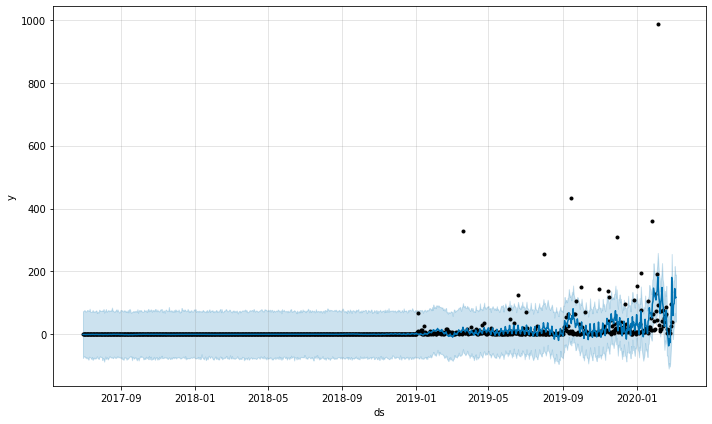

In [25]:
print('20% less then competition')
m.plot(fcst)
plt.show()

In [26]:
temp.tail(4)

,ds,group_type_price,delta_price,y
230069,2020-02-07,electronics_Botoeira de sobrepor_D,NaN,0.0
230345,2020-02-08,electronics_Botoeira de sobrepor_D,NaN,0.0
230619,2020-02-09,electronics_Botoeira de sobrepor_D,NaN,0.0
230891,2020-02-10,electronics_Botoeira de sobrepor_D,NaN,0.0


In [27]:
fcst.tail(7)[['ds','delta_price','yhat']]

,ds,delta_price,yhat
974,2020-02-29,2.95155,79.472476
975,2020-03-01,2.95155,59.727762
976,2020-03-02,2.95155,95.035437
977,2020-03-03,2.95155,97.146377
978,2020-03-04,2.95155,145.578132
979,2020-03-05,2.95155,115.505463
980,2020-03-06,2.95155,117.730910


40% less then competition


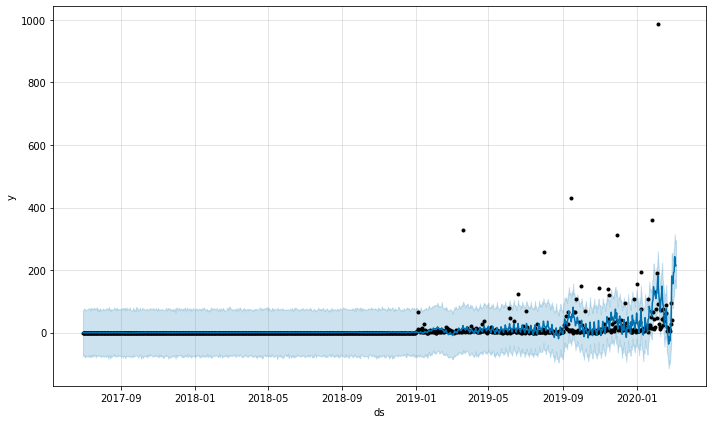

In [31]:
print('40% less then competition')
m.plot(fcst)
plt.show()

In [32]:
fcst.tail(7)[['ds','delta_price','yhat']]

,ds,delta_price,yhat
974,2020-02-29,5.575622,175.619903
975,2020-03-01,5.575622,156.133971
976,2020-03-02,5.575622,191.700428
977,2020-03-03,5.575622,194.070150
978,2020-03-04,5.575622,242.760686
979,2020-03-05,5.575622,212.946800
980,2020-03-06,5.575622,215.431028


equal to competition


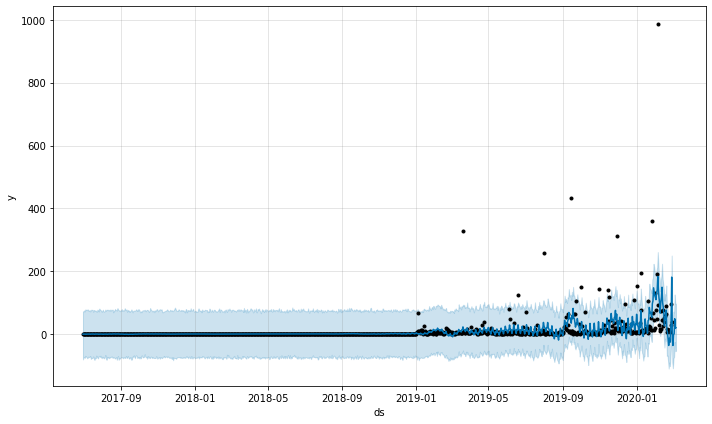

In [36]:
print('equal to competition')
m.plot(fcst)
plt.show()

In [37]:
fcst.tail(7)[['ds','delta_price','yhat']]

,ds,delta_price,yhat
974,2020-02-29,0.327478,-16.674950
975,2020-03-01,0.327478,-36.678447
976,2020-03-02,0.327478,-1.629554
977,2020-03-03,0.327478,0.222604
978,2020-03-04,0.327478,48.395577
979,2020-03-05,0.327478,18.064126
980,2020-03-06,0.327478,20.030791


20% above competition


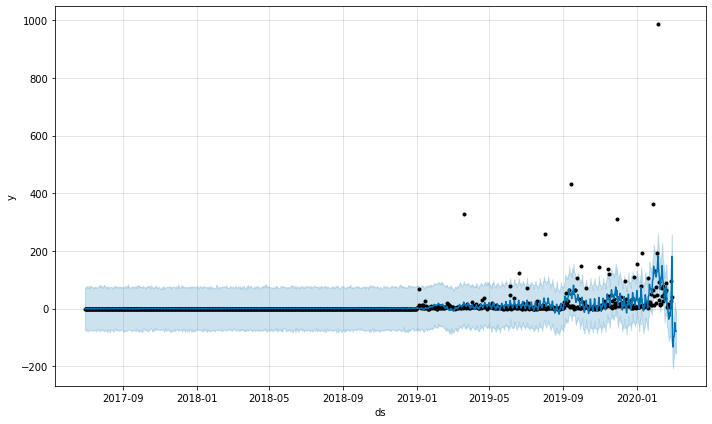

In [41]:
print('20% above competition')
m.plot(fcst)
plt.show()

In [42]:
fcst.tail(7)[['ds','delta_price','yhat']]

,ds,delta_price,yhat
974,2020-02-29,-2.296595,-112.822377
975,2020-03-01,-2.296595,-133.084656
976,2020-03-02,-2.296595,-98.294544
977,2020-03-03,-2.296595,-96.701168
978,2020-03-04,-2.296595,-48.786978
979,2020-03-05,-2.296595,-79.377210
980,2020-03-06,-2.296595,-77.669327


### TODO: Parameters Search + modelling Competition Prices, Olist Prices and Shipping Values + calculate estimated reward.
Try to calculate the estimated rewards based on the final prices;  
Use grid or random search for parameters to optimize reward;  